# Scripting a renderer

## Overview

Mitsuba can not only be used as a renderer as shown in the previous tutorials, but also as a toolkit to develop your own rendering applications from scratch. In this example, we are going to bypass the traditional Mitsuba pipeline and implement an ambient occlusion renderer using building blocks provided by the Mitsuba library. This highly customisable script is a great starting point for those interested in using Mitsuba on unconventional applications.

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
<ul>
  <li>Spawn wavefront of rays in Python</li>
  <li>Generate random numbers with the <tt>PCG32</tt> class</li>  
  <li>Work with <tt>Loop</tt></li>
  <li>Use Mitsuba as a toolkit to write your own rendering application</li>
</ul>
    
</div>


## Setup

Like in the previous tutorials, we start by importing the libraries and loading the Cornell Box scene.

In [1]:
import mitsuba as mi
import drjit as dr

mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../../scenes/cbox.xml')

## Spawn rays

In this tutorial, we are trying to avoid using the built-in plugins and their instances present in the scene. Instead, we will do things manually in Python!

This starts with the camera and the rays generation. In this experiment, we will implement a simple orthographic camera, given the following parameters:

In [2]:
# Camera origin in world space
cam_origin = mi.Point3f(0, 1, 3)

# Camera direction in world space
cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))

# Camera width and height in world space
cam_width  = 1.0
cam_height = 1.0

# Image pixel resolution
image_res = [256, 256]

While it is possible to use Mitsuba from Python in `scalar` mode, it is highly recommended to stick to the "vectorized" variants of the system for performance critical applications (e.g. we don't want to pay the overhead of the Python binding layer at every function call on every individual sample/ray in our simulation). For this, we are going to generate a whole wavefront of rays that will be processed all at once in a vectorized way (either on the CPU with `llvm` or on the GPU with `cuda`).

Similarly to Numpy, by using DrJit rountines such as `dr.meshgrid` and `dr.linspace`, it is easy to construct a grid of 2D coordinates uniformly scattered in $[-W, -H] \times [W, H]$.

Setting the 3rd dimension to zero, those `x` and `y` coordinates can be used to create a offset vector in screen space (here `screen_offset`).

Those offsets need to be transformed into world space to account for the camera direction. This can be achieved using the [<code>mi.Frame3f</code>][1] class. Given the direction of the principal axis, this class constructs a full coordinate system and provides methods to transfrom points and vectors from and to this space. Here we use the [<code>to_world()</code>][2] method to transfrom the pixel offsets from sceen space into world space. 

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f.to_world

In [3]:
# Construct a grid of 2D coordinates
x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width,   cam_width,  image_res[0]),
    dr.linspace(mi.Float, -cam_height,  cam_height, image_res[1]),
)

# Offsets in screen space
screen_offset = mi.Vector3f(x, y, 0)

# Offsets in world space
pixel_offset = mi.Frame3f(cam_dir).to_world(screen_offset)

Finally we are able to assemble a wavefront of rays that will later be traced in our custom integrator.

In [4]:
rays = mi.Ray3f(
    o=cam_origin + pixel_offset, 
    d=cam_dir
)

We can now trace those primary rays against the scene geometry to compute the corresponding surface interactions ([<code>SurfaceInteraction3f</code>][1] objects).

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f

In [5]:
si = scene.ray_intersect(rays)

## Ambient occlusion

Ambient occlusion is a rendering technique that calculates how exposed surfaces in the scene are to ambient lighting. For this, at each surface interactions we trace a set of rays (`ambient_ray_count`) in random directions and count how many of those didn't interact with another surface in a specific range (`ambient_range`).

In [6]:
ambient_range = 1.8
ambient_ray_count = 256

In order to sample directions for the ambient occlusion rays, we will need a random number generator. Instead of using the `Sampler` instance in the scene, in this tutorial we are going to use the [<code>PCG32</code>][1] class to generate those numbers. In its constructor, we specify the size of the expected random array to match the size of our wavefront of rays. We will then be able to generate random numbers using the [<code>Sampler.next_float32()</code>][2] method of this class.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.PCG32
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler.next_float32

In [7]:
# Initialize the random number generator
rng = mi.PCG32(size=dr.hprod(image_res))

In the following code, we will use a `mi.Loop` for performance reasons explained in more details in the [DrJIT documentation][1]

The loop body of this algorithm is fairly simple: 

1. We first draw two random numbers from the `PCG32` instance. 
2. We use those random numbers compute directions on the hemisphere (in local space, e.g. z-axis pointing upward). 
3. Those directions then need to be transformed in world space based on the surface orientation at each interaction. Fortunately, `si` ([<code>SurfaceInteraction3f</code>][2]) provides a local shading frame ([<code>Frame3f</code>][3]) that we use here to perform such transformation.
4. Given the world space directions, we spawn rays starting at the surface interactions. The `spawn_ray` method implements some logic to prevent self-intersection with the surface at `si`. It should always be prefered over constructing the ray manually in such situations.
5. We override the maximum segment ray of the ambiant ray to only find occluders in the ambient range.
6. We accumulate the ambient energy (here `1.0`) only when the result of the ray test is negatif (e.g. is hasn't find any geometry in the ambient range).
7. Finally we increment the loop iteration counter and move on to the next iteration

[1]: https://mitsuba3.readthedocs.io/en/latest/src/404.html
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f

In [8]:
# Loop iteration counter
i = mi.UInt32(0)

# Accumulated ambient energy
result = mi.Float(0)

# Initialize the loop state (e.g. variables that change accross iterations)
loop = mi.Loop(name="", state=lambda: (rng, i, result))

# Loop performing the ambient occlusion computations
while loop(si.is_valid() & (i < ambient_ray_count)):
    # 1. Draw some random numbers
    sample_1, sample_2 = rng.next_float32(), rng.next_float32()
    
    # 2. Compute directions on the hemisphere using the random numbers
    wo_local = mi.warp.square_to_uniform_hemisphere([sample_1, sample_2])
    
    # 3. Transform the sampled directions to world space
    wo_world = si.sh_frame.to_world(wo_local)

    # 4. Spawn a new ray starting at the surface interactions
    ray_2 = si.spawn_ray(wo_world)
    
    # 5. Set a maximum ray segment length to only account for the close-by geometry
    ray_2.maxt = ambient_range

    # 6. Accumulate ambient energy if not occluded
    result[~scene.ray_test(ray_2)] += 1.0
    
    # 7. Increase loop iteration counter
    i += 1

## Image formation

The algorithm above accumulated ambient energy in the 1-dimentional `result` array. In order to work with this array as an image, we need to give it a shape, which can be done using the [<code>TensorXf</code>][1] class. 

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf

In [9]:
image = mi.TensorXf(result, shape=image_res)

Let's visualize our ambient occlusion rendering!

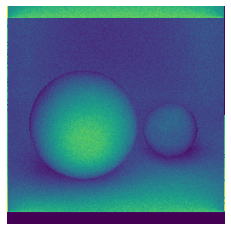

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image); plt.axis('off');

## See also

- [<code>mitsuba.Sampler</code>][1]
- [<code>mitsuba.PCG32</code>][2]
- [<code>mitsuba.warp.square_to_uniform_hemisphere()</code>][3]
- [<code>mitsuba.SurfaceInteraction3f.spawn_ray()</code>][4]

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.PCG32
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.warp.square_to_uniform_hemisphere
[4]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f.spawn_ray